In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 2
2023-07-31 08:09:05.138134


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-12.9182)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(8.5986)
penalty_target_min tensor(-11.6229) penalty_target_max tensor(5.3304)
train_loss:  -8.42597192583084
valid_loss:  -8.129956848144532
h_min_tilde -11.622948 ell_tilde -8.366768910293578 kappa_tilde 0.0005541736588958331


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.638864517211914

 2 3.9664785861968994

 3 3.458132743835449

 4 5.294774055480957

 5 7.356391906738281

 6 3.563732624053955

 7 3.6274800300598145

 8 3.7489140033721924

 9 3.750992774963379

 10 4.0062994956970215

 11 3.677804470062256

 12 3.6179630756378174

 13 3.6180050373077393

 14 4.934831619262695

 15 6.239630937576294

 16 3.548139810562134

 17 5.005921840667725

 18 5.403975009918213

 19 7.304768085479736

 20 6.659357070922852

 21 3.7597625255584717

 22 3.6939985752105713

 23 3.5584897994995117

 24 3.600762367248535

 25 3.944653272628784

 26 3.6634180545806885

 27 3.610114336013794

 28 3.926126718521118

 29 3.8058273792266846

 30 3.93263578414917

 31 3.68812894821167

 32 3.7144131660461426

 33 3.9805009365081787

 34 3.6364457607269287

 35 3.8851163387298584

 36 3.703268527984619

 37 3.9478602409362793

 38 3.7218363285064697

 39 3.520092010498047

 40 3.799301862716675

 41 4.022213697433472

 42 3.632537841796875

 43 5.01828932762146

 44 6

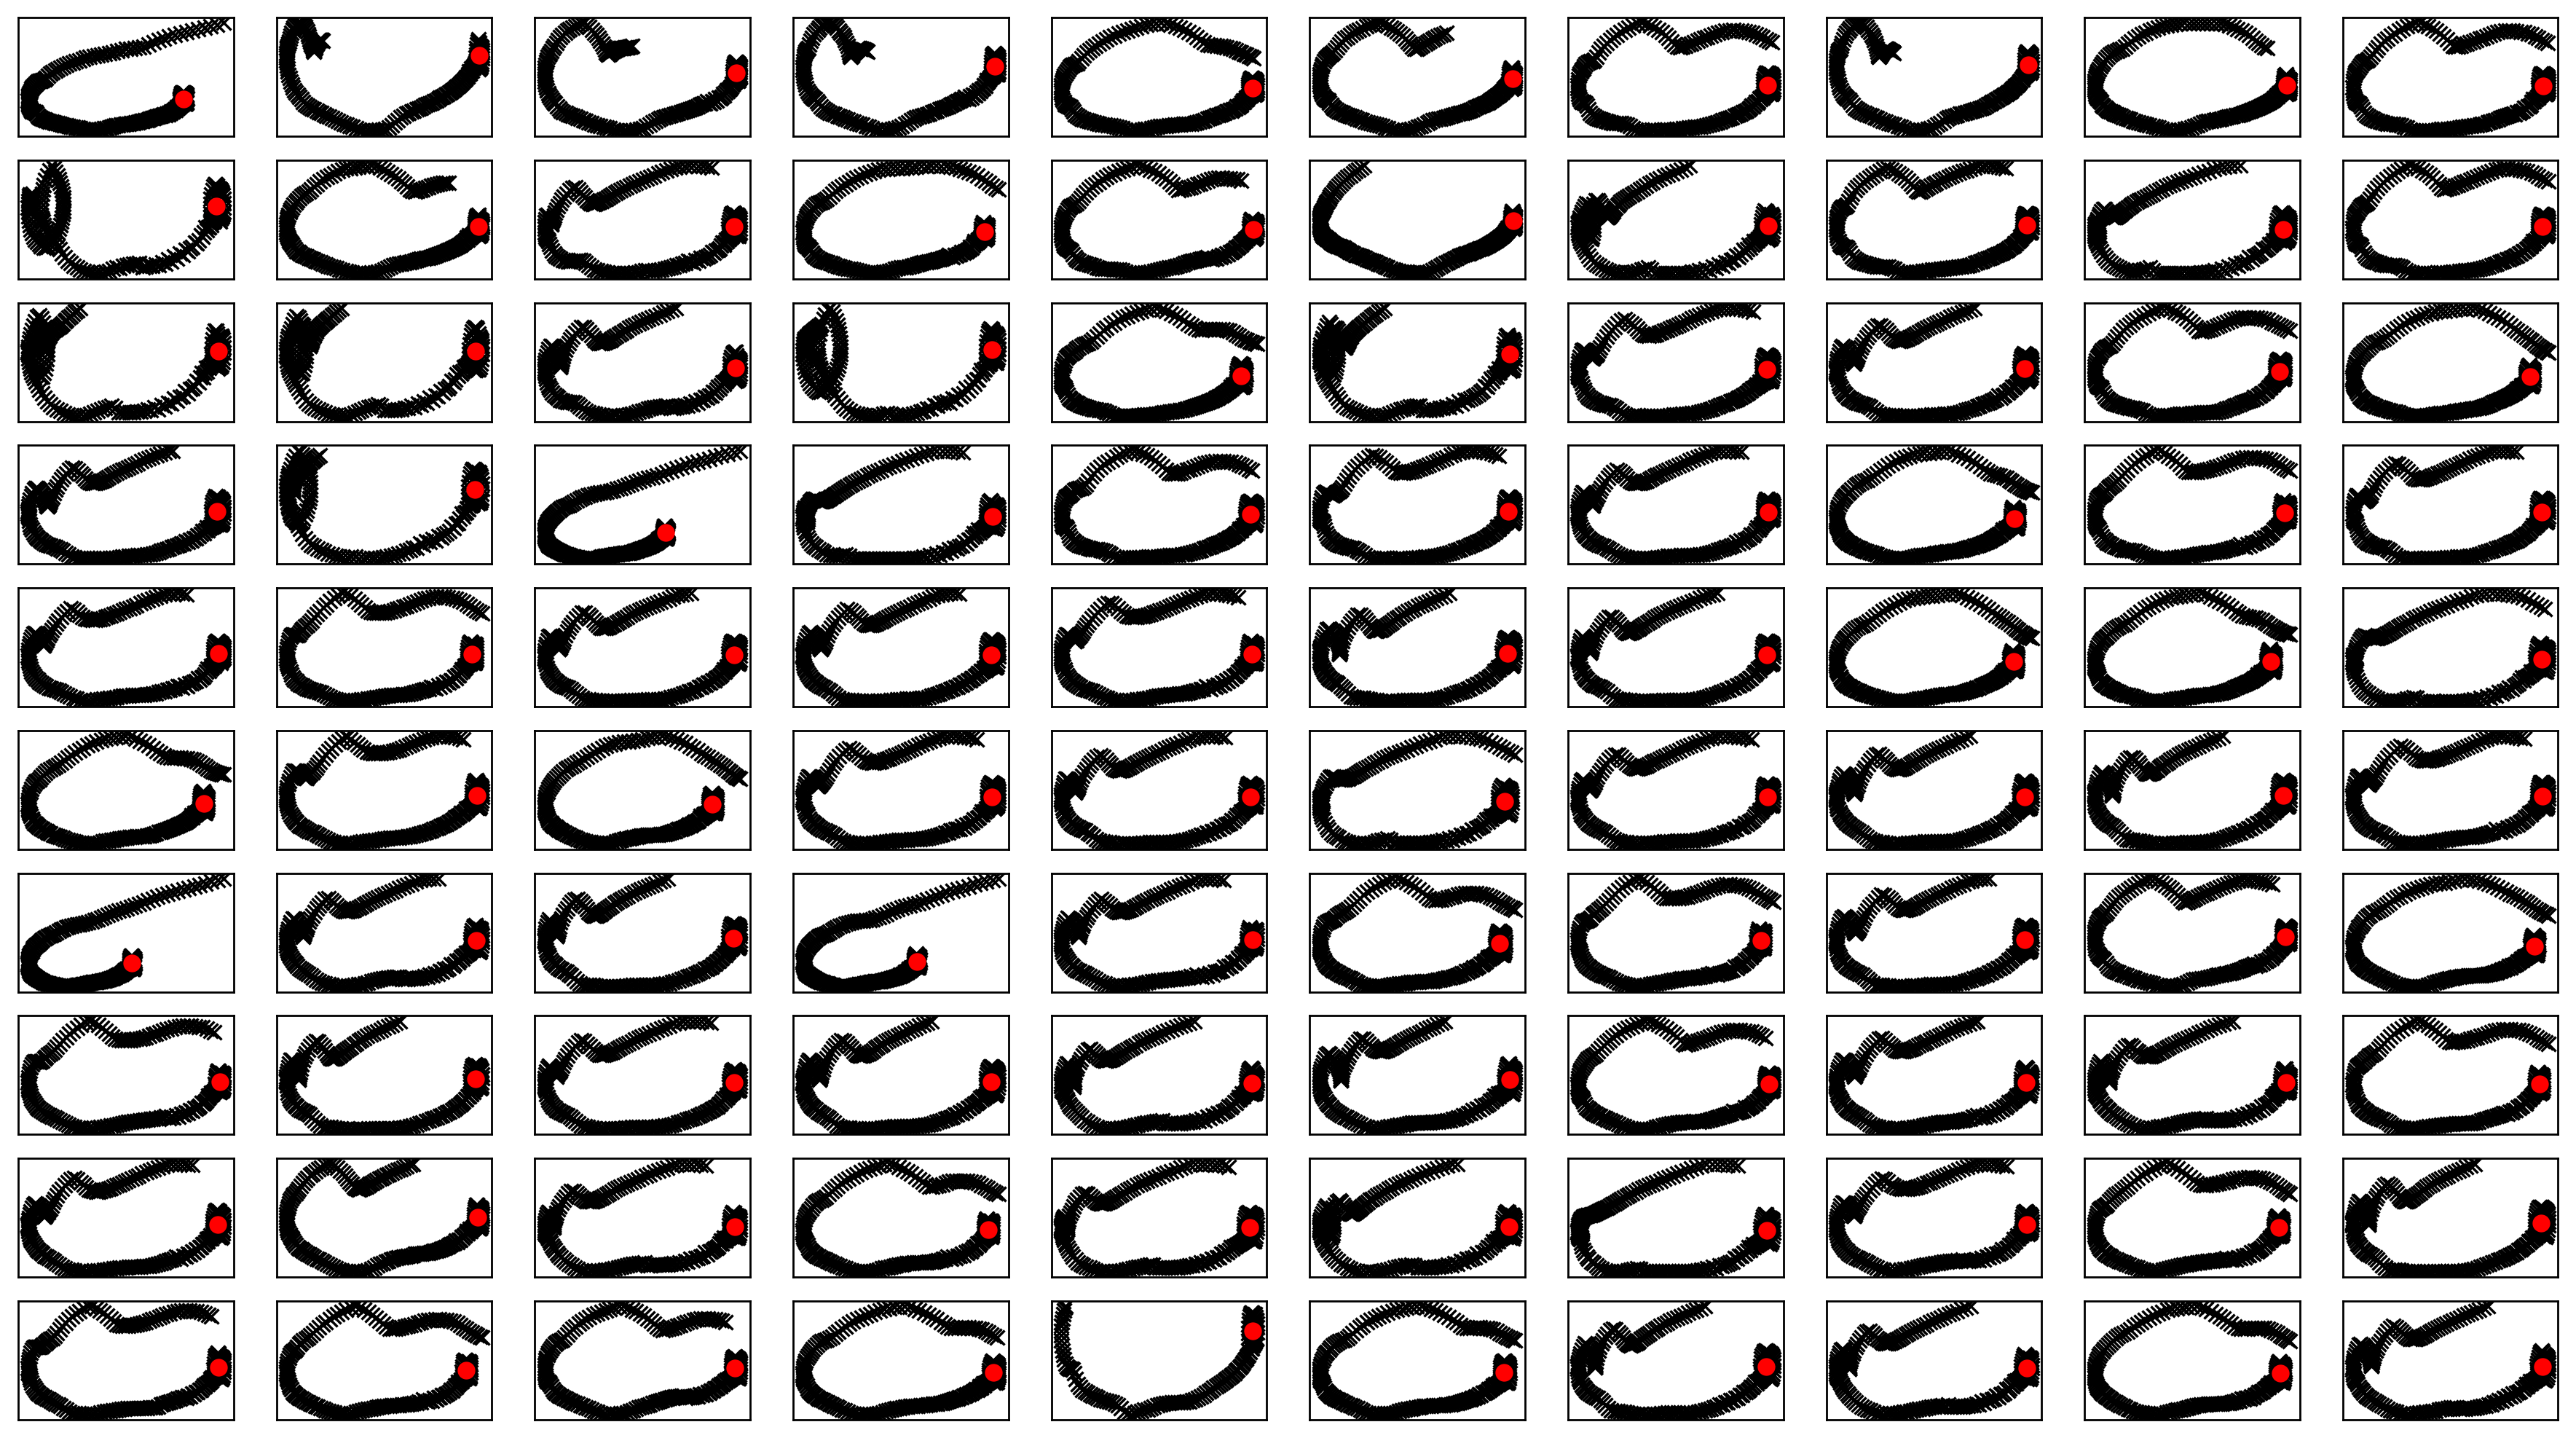

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

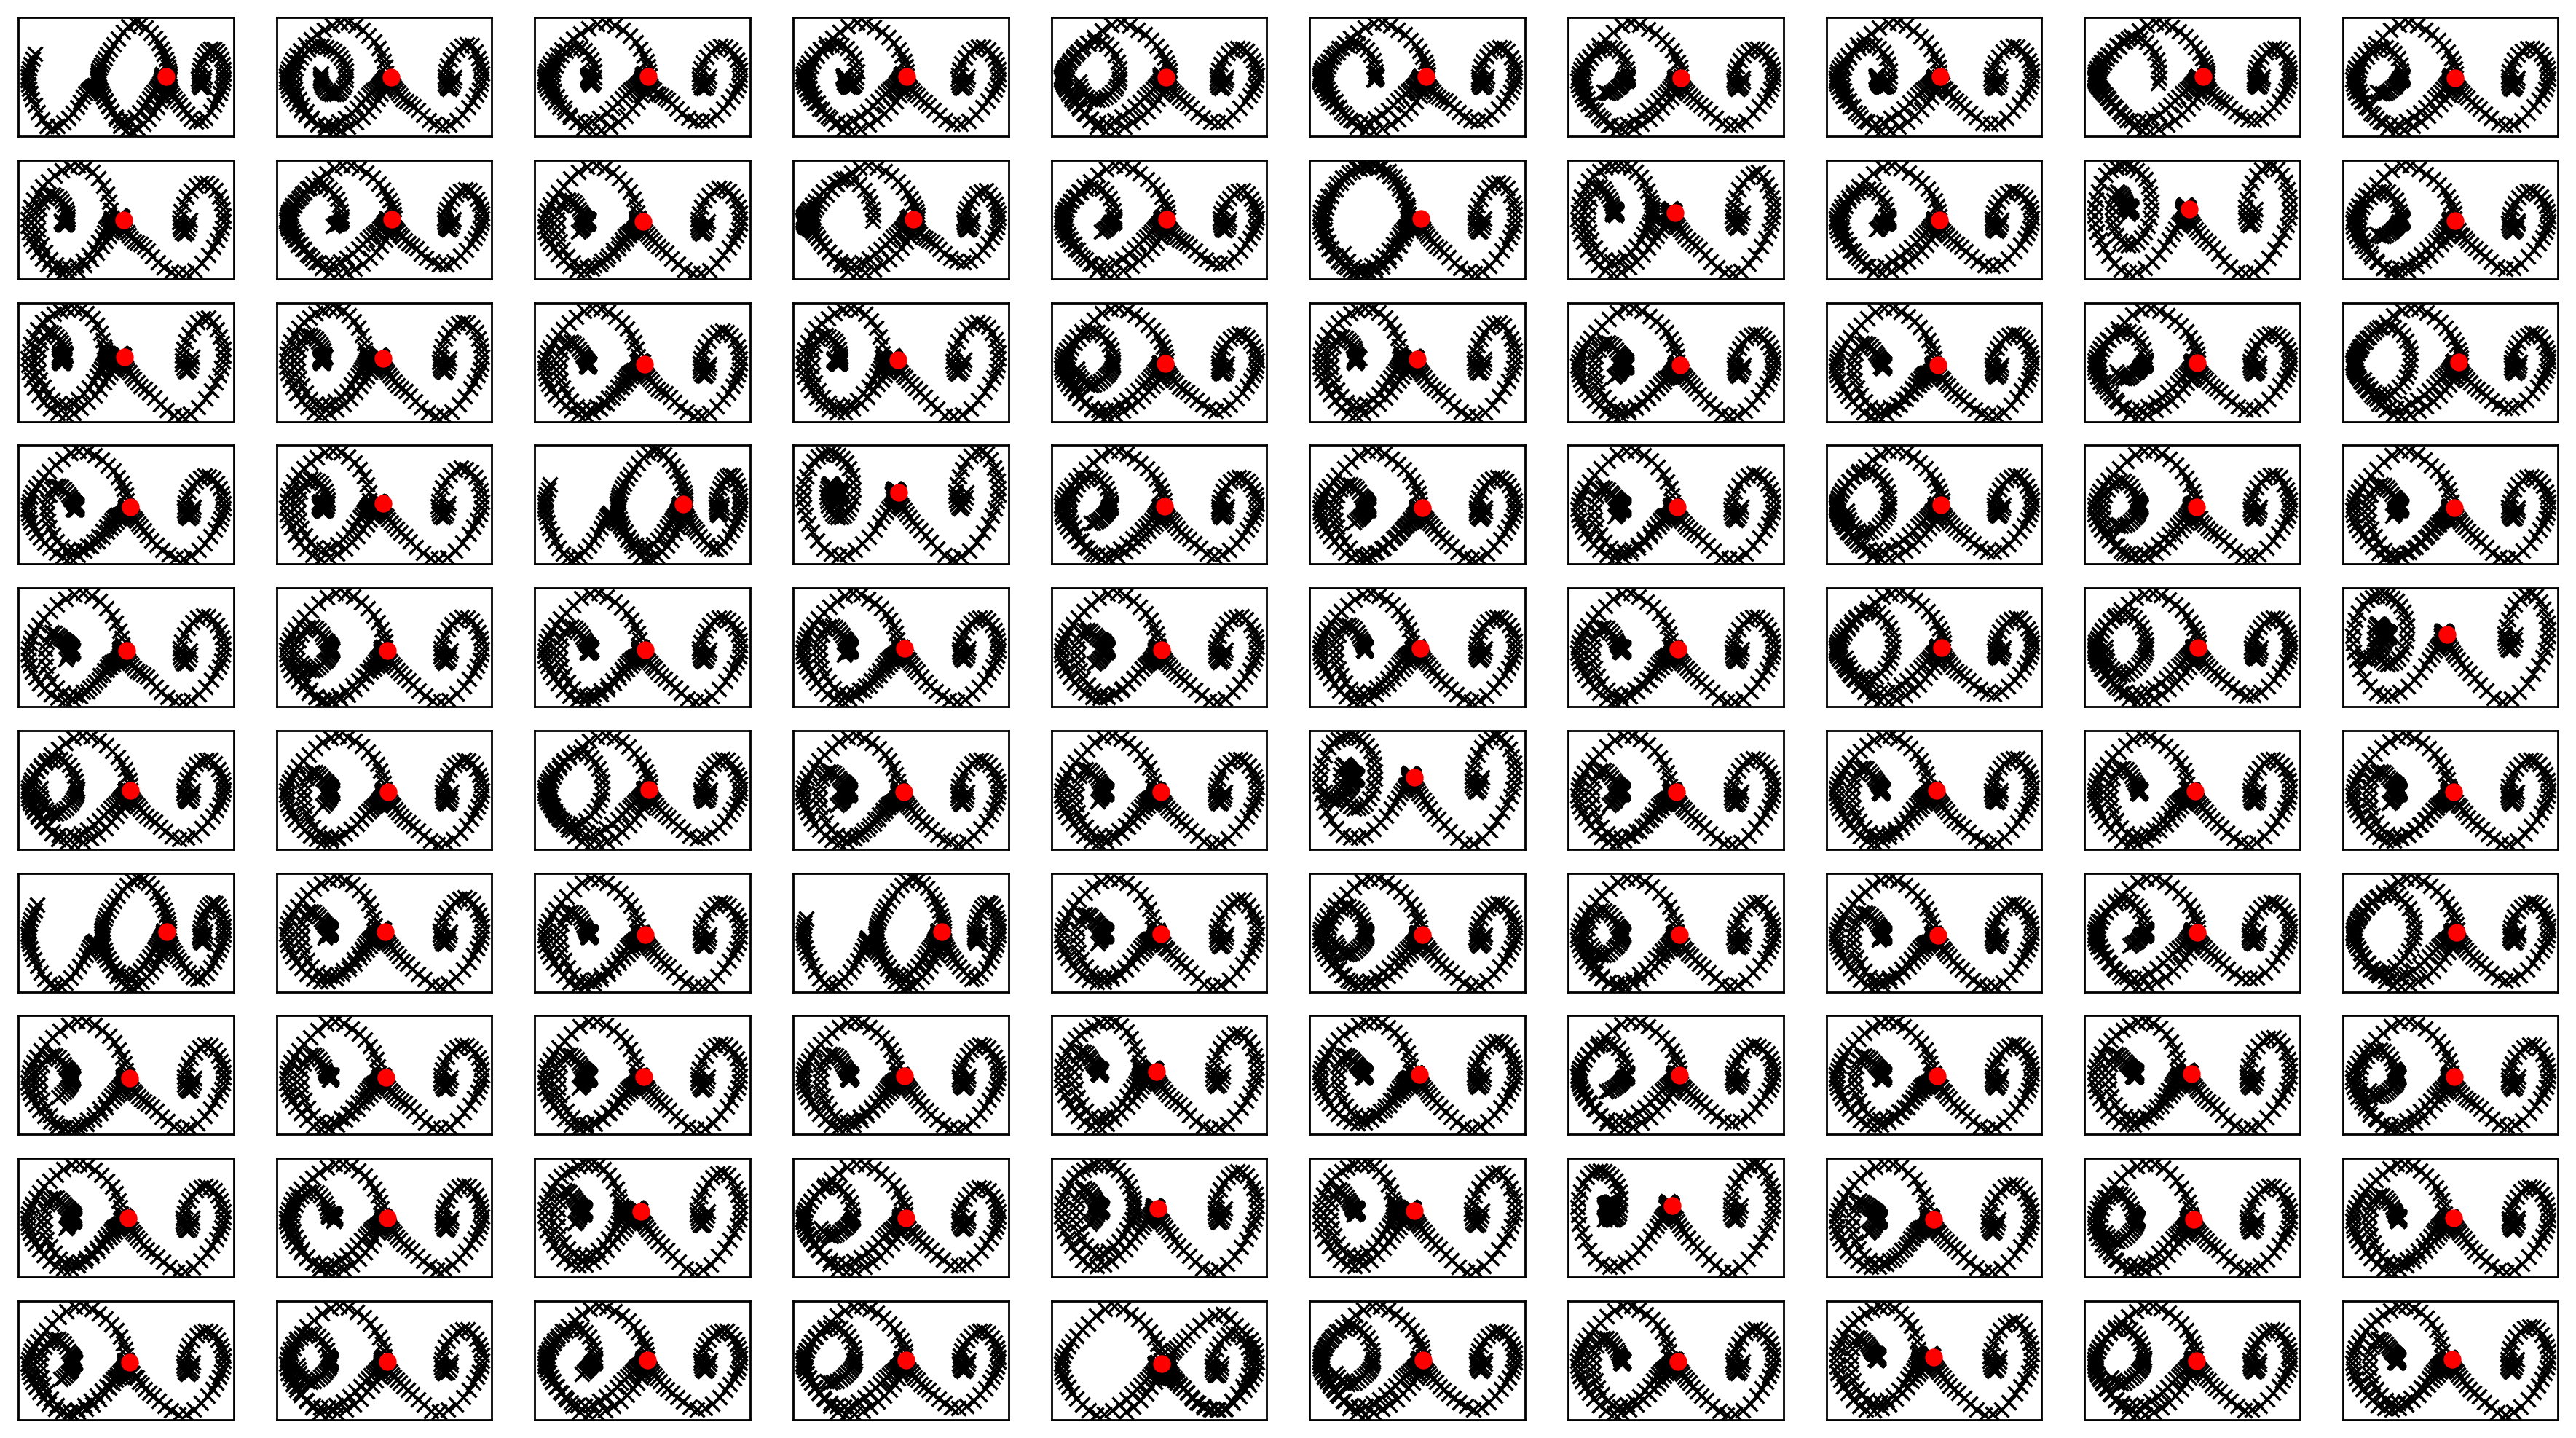

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-31 08:16:47.189669


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.35309  validloss 1.42762±0.00000  bestvalidloss 1.42762  last_update 0
train: iter 1  trainloss 1.25174  validloss 1.29669±0.00000  bestvalidloss 1.29669  last_update 0
train: iter 2  trainloss 1.10836  validloss 1.15915±0.00000  bestvalidloss 1.15915  last_update 0
train: iter 3  trainloss 0.95153  validloss 0.98315±0.00000  bestvalidloss 0.98315  last_update 0
train: iter 4  trainloss 0.83468  validloss 0.82469±0.00000  bestvalidloss 0.82469  last_update 0
train: iter 5  trainloss 0.75783  validloss 0.73317±0.00000  bestvalidloss 0.73317  last_update 0
train: iter 6  trainloss 0.70528  validloss 0.66405±0.00000  bestvalidloss 0.66405  last_update 0
train: iter 7  trainloss 0.67070  validloss 0.62362±0.00000  bestvalidloss 0.62362  last_update 0
train: iter 8  trainloss 0.63976  validloss 0.60197±0.00000  bestvalidloss 0.60197  last_update 0
train: iter 9  trainloss 0.61644  validloss 0.57444±0.00000  bestvalidloss 0.57444  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.39616  validloss 0.39947±0.00000  bestvalidloss 0.39505  last_update 15
train: iter 84  trainloss 0.38814  validloss 0.40246±0.00000  bestvalidloss 0.39505  last_update 16
train: iter 85  trainloss 0.38507  validloss 0.38921±0.00000  bestvalidloss 0.38921  last_update 0
train: iter 86  trainloss 0.37796  validloss 0.43854±0.00000  bestvalidloss 0.38921  last_update 1
train: iter 87  trainloss 0.38732  validloss 0.41425±0.00000  bestvalidloss 0.38921  last_update 2
train: iter 88  trainloss 0.37917  validloss 0.44895±0.00000  bestvalidloss 0.38921  last_update 3
train: iter 89  trainloss 0.38318  validloss 0.39121±0.00000  bestvalidloss 0.38921  last_update 4
train: iter 90  trainloss 0.39418  validloss 0.40423±0.00000  bestvalidloss 0.38921  last_update 5
train: iter 91  trainloss 0.37917  validloss 0.39665±0.00000  bestvalidloss 0.38921  last_update 6
train: iter 92  trainloss 0.38018  validloss 0.38680±0.00000  bestvalidloss 0.38680  last_update 0
train: i

train: iter 166  trainloss 0.33890  validloss 0.40583±0.00000  bestvalidloss 0.35695  last_update 13
train: iter 167  trainloss 0.34297  validloss 0.38907±0.00000  bestvalidloss 0.35695  last_update 14
train: iter 168  trainloss 0.34011  validloss 0.35519±0.00000  bestvalidloss 0.35519  last_update 0
train: iter 169  trainloss 0.33297  validloss 0.35436±0.00000  bestvalidloss 0.35436  last_update 0
train: iter 170  trainloss 0.33961  validloss 0.36345±0.00000  bestvalidloss 0.35436  last_update 1
train: iter 171  trainloss 0.33392  validloss 0.36565±0.00000  bestvalidloss 0.35436  last_update 2
train: iter 172  trainloss 0.33854  validloss 0.37530±0.00000  bestvalidloss 0.35436  last_update 3
train: iter 173  trainloss 0.33480  validloss 0.36949±0.00000  bestvalidloss 0.35436  last_update 4
train: iter 174  trainloss 0.33317  validloss 0.36946±0.00000  bestvalidloss 0.35436  last_update 5
train: iter 175  trainloss 0.33397  validloss 0.35575±0.00000  bestvalidloss 0.35436  last_update 

train: iter 248  trainloss 0.31667  validloss 0.36681±0.00000  bestvalidloss 0.34115  last_update 30
train: iter 249  trainloss 0.32118  validloss 0.35310±0.00000  bestvalidloss 0.34115  last_update 31
train: iter 250  trainloss 0.31156  validloss 0.33867±0.00000  bestvalidloss 0.33867  last_update 0
train: iter 251  trainloss 0.30967  validloss 0.35818±0.00000  bestvalidloss 0.33867  last_update 1
train: iter 252  trainloss 0.31213  validloss 0.36649±0.00000  bestvalidloss 0.33867  last_update 2
train: iter 253  trainloss 0.31463  validloss 0.34569±0.00000  bestvalidloss 0.33867  last_update 3
train: iter 254  trainloss 0.31187  validloss 0.35579±0.00000  bestvalidloss 0.33867  last_update 4
train: iter 255  trainloss 0.31084  validloss 0.35532±0.00000  bestvalidloss 0.33867  last_update 5
train: iter 256  trainloss 0.31735  validloss 0.35136±0.00000  bestvalidloss 0.33867  last_update 6
train: iter 257  trainloss 0.32152  validloss 0.36349±0.00000  bestvalidloss 0.33867  last_update 

train: iter 330  trainloss 0.29822  validloss 0.35026±0.00000  bestvalidloss 0.33721  last_update 35
train: iter 331  trainloss 0.29760  validloss 0.34021±0.00000  bestvalidloss 0.33721  last_update 36
train: iter 332  trainloss 0.29220  validloss 0.35120±0.00000  bestvalidloss 0.33721  last_update 37
train: iter 333  trainloss 0.29815  validloss 0.39817±0.00000  bestvalidloss 0.33721  last_update 38
train: iter 334  trainloss 0.30264  validloss 0.34435±0.00000  bestvalidloss 0.33721  last_update 39
train: iter 335  trainloss 0.29562  validloss 0.34670±0.00000  bestvalidloss 0.33721  last_update 40
train: iter 336  trainloss 0.30803  validloss 0.34466±0.00000  bestvalidloss 0.33721  last_update 41
train: iter 337  trainloss 0.29675  validloss 0.33187±0.00000  bestvalidloss 0.33187  last_update 0
train: iter 338  trainloss 0.29520  validloss 0.35268±0.00000  bestvalidloss 0.33187  last_update 1
train: iter 339  trainloss 0.29963  validloss 0.34913±0.00000  bestvalidloss 0.33187  last_up

train: iter 412  trainloss 0.28570  validloss 0.34853±0.00000  bestvalidloss 0.33187  last_update 75
train: iter 413  trainloss 0.28464  validloss 0.33801±0.00000  bestvalidloss 0.33187  last_update 76
train: iter 414  trainloss 0.28777  validloss 0.35079±0.00000  bestvalidloss 0.33187  last_update 77
train: iter 415  trainloss 0.28193  validloss 0.34292±0.00000  bestvalidloss 0.33187  last_update 78
train: iter 416  trainloss 0.28406  validloss 0.35726±0.00000  bestvalidloss 0.33187  last_update 79
train: iter 417  trainloss 0.28724  validloss 0.33499±0.00000  bestvalidloss 0.33187  last_update 80
train: iter 418  trainloss 0.28688  validloss 0.33699±0.00000  bestvalidloss 0.33187  last_update 81
train: iter 419  trainloss 0.28822  validloss 0.34939±0.00000  bestvalidloss 0.33187  last_update 82
train: iter 420  trainloss 0.28617  validloss 0.32945±0.00000  bestvalidloss 0.32945  last_update 0
train: iter 421  trainloss 0.28231  validloss 0.34536±0.00000  bestvalidloss 0.32945  last_u

train: iter 494  trainloss 0.27541  validloss 0.34148±0.00000  bestvalidloss 0.32945  last_update 74
train: iter 495  trainloss 0.27376  validloss 0.33379±0.00000  bestvalidloss 0.32945  last_update 75
train: iter 496  trainloss 0.27630  validloss 0.34066±0.00000  bestvalidloss 0.32945  last_update 76
train: iter 497  trainloss 0.27948  validloss 0.34542±0.00000  bestvalidloss 0.32945  last_update 77
train: iter 498  trainloss 0.27767  validloss 0.34056±0.00000  bestvalidloss 0.32945  last_update 78
train: iter 499  trainloss 0.27549  validloss 0.34417±0.00000  bestvalidloss 0.32945  last_update 79
train: iter 500  trainloss 0.27401  validloss 0.33721±0.00000  bestvalidloss 0.32945  last_update 80
train: iter 501  trainloss 0.27830  validloss 0.33518±0.00000  bestvalidloss 0.32945  last_update 81
train: iter 502  trainloss 0.27442  validloss 0.34460±0.00000  bestvalidloss 0.32945  last_update 82
train: iter 503  trainloss 0.27000  validloss 0.34076±0.00000  bestvalidloss 0.32945  last_

train: iter 576  trainloss 0.26423  validloss 0.35897±0.00000  bestvalidloss 0.32833  last_update 63
train: iter 577  trainloss 0.26829  validloss 0.34512±0.00000  bestvalidloss 0.32833  last_update 64
train: iter 578  trainloss 0.26383  validloss 0.35278±0.00000  bestvalidloss 0.32833  last_update 65
train: iter 579  trainloss 0.26138  validloss 0.33320±0.00000  bestvalidloss 0.32833  last_update 66
train: iter 580  trainloss 0.26303  validloss 0.35172±0.00000  bestvalidloss 0.32833  last_update 67
train: iter 581  trainloss 0.26262  validloss 0.33817±0.00000  bestvalidloss 0.32833  last_update 68
train: iter 582  trainloss 0.26257  validloss 0.34232±0.00000  bestvalidloss 0.32833  last_update 69
train: iter 583  trainloss 0.26430  validloss 0.34225±0.00000  bestvalidloss 0.32833  last_update 70
train: iter 584  trainloss 0.26327  validloss 0.34551±0.00000  bestvalidloss 0.32833  last_update 71
train: iter 585  trainloss 0.26227  validloss 0.33631±0.00000  bestvalidloss 0.32833  last_

train_loss:  -3.4674941608250136
valid_loss:  -4.5311501776695255
weight_alpha 1.0 h_min_tilde -11.622948 ell_tilde -3.680225364193916 kappa_tilde 0.0003548258974502004
train_loss:  -3.1982066178798676
valid_loss:  -2.904276085662842
weight_alpha 0.1 h_min_tilde -11.622948 ell_tilde -3.139420511436463 kappa_tilde 0.00034333001474464353


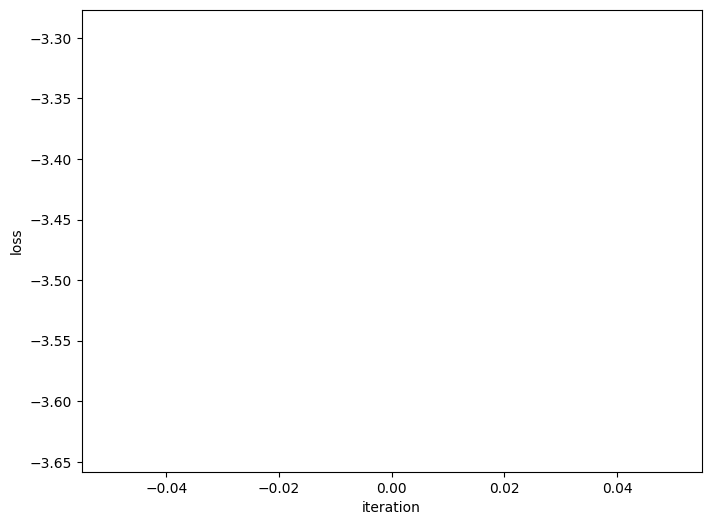

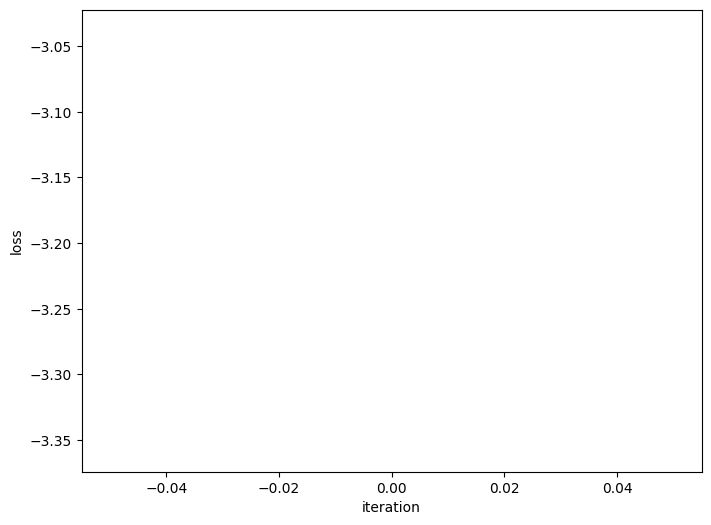

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -606.39912  validloss -580.18473±0.00000  bestvalidloss -580.18473  last_update 0
train: iter 1  trainloss -616.78097  validloss -530.27965±0.00000  bestvalidloss -580.18473  last_update 1
train: iter 2  trainloss -619.64250  validloss -567.68487±0.00000  bestvalidloss -580.18473  last_update 2
train: iter 3  trainloss -628.90337  validloss -560.65757±0.00000  bestvalidloss -580.18473  last_update 3
train: iter 4  trainloss -618.80297  validloss -548.03458±0.00000  bestvalidloss -580.18473  last_update 4
train: iter 5  trainloss -573.33957  validloss -554.79052±0.00000  bestvalidloss -580.18473  last_update 5
train: iter 6  trainloss -608.86736  validloss -532.46634±0.00000  bestvalidloss -580.18473  last_update 6
train: iter 7  trainloss -611.15588  validloss -555.18447±0.00000  bestvalidloss -580.18473  last_update 7
train: iter 8  trainloss -615.59656  validloss -535.60237±0.00000  bestvalidloss -580.18473  last_u

train: iter 76  trainloss -595.52081  validloss -551.09610±0.00000  bestvalidloss -593.11623  last_update 62
train: iter 77  trainloss -540.55036  validloss -494.19327±0.00000  bestvalidloss -593.11623  last_update 63
train: iter 78  trainloss -620.96539  validloss -525.37931±0.00000  bestvalidloss -593.11623  last_update 64
train: iter 79  trainloss -626.40550  validloss -541.22292±0.00000  bestvalidloss -593.11623  last_update 65
train: iter 80  trainloss -625.66060  validloss -542.18557±0.00000  bestvalidloss -593.11623  last_update 66
train: iter 81  trainloss -628.65467  validloss -529.59156±0.00000  bestvalidloss -593.11623  last_update 67
train: iter 82  trainloss -627.97378  validloss -553.93716±0.00000  bestvalidloss -593.11623  last_update 68
train: iter 83  trainloss -635.25423  validloss -556.54598±0.00000  bestvalidloss -593.11623  last_update 69
train: iter 84  trainloss -605.35679  validloss -546.03731±0.00000  bestvalidloss -593.11623  last_update 70
train: iter 85  tra

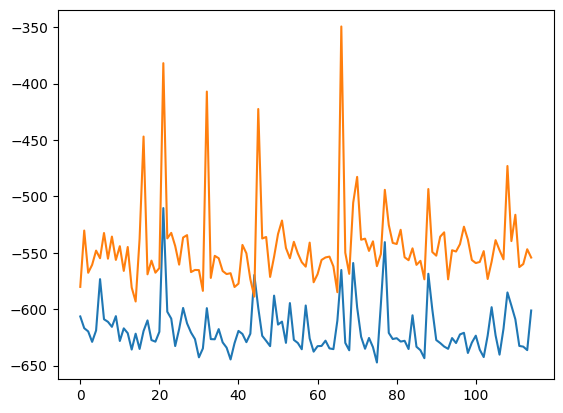

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-31 08:45:17.806903


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.32927  validloss 0.65829±0.00000  bestvalidloss 0.65829  last_update 0
train: iter 1  trainloss 0.30906  validloss 0.34884±0.00000  bestvalidloss 0.34884  last_update 0
train: iter 2  trainloss 0.29836  validloss 0.32929±0.00000  bestvalidloss 0.32929  last_update 0
train: iter 3  trainloss 0.29624  validloss 0.32574±0.00000  bestvalidloss 0.32574  last_update 0
train: iter 4  trainloss 0.29190  validloss 0.32483±0.00000  bestvalidloss 0.32483  last_update 0
train: iter 5  trainloss 0.29255  validloss 0.33040±0.00000  bestvalidloss 0.32483  last_update 1
train: iter 6  trainloss 0.29460  validloss 0.32954±0.00000  bestvalidloss 0.32483  last_update 2
train: iter 7  trainloss 0.29317  validloss 0.31984±0.00000  bestvalidloss 0.31984  last_update 0
train: iter 8  trainloss 0.28727  validloss 0.31964±0.00000  bestvalidloss 0.31964  last_update 0
train: iter 9  trainloss 0.28793  validloss 0.33537±0.00000  bestvalidloss 0.31964  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.26517  validloss 0.30541±0.00000  bestvalidloss 0.30159  last_update 15
train: iter 84  trainloss 0.27056  validloss 0.30611±0.00000  bestvalidloss 0.30159  last_update 16
train: iter 85  trainloss 0.27174  validloss 0.32118±0.00000  bestvalidloss 0.30159  last_update 17
train: iter 86  trainloss 0.26707  validloss 0.31540±0.00000  bestvalidloss 0.30159  last_update 18
train: iter 87  trainloss 0.26556  validloss 0.30546±0.00000  bestvalidloss 0.30159  last_update 19
train: iter 88  trainloss 0.26560  validloss 0.31316±0.00000  bestvalidloss 0.30159  last_update 20
train: iter 89  trainloss 0.26805  validloss 0.31179±0.00000  bestvalidloss 0.30159  last_update 21
train: iter 90  trainloss 0.26643  validloss 0.30298±0.00000  bestvalidloss 0.30159  last_update 22
train: iter 91  trainloss 0.26721  validloss 0.31880±0.00000  bestvalidloss 0.30159  last_update 23
train: iter 92  trainloss 0.27078  validloss 0.31060±0.00000  bestvalidloss 0.30159  last_update 24


train: iter 165  trainloss 0.25897  validloss 0.31649±0.00000  bestvalidloss 0.30055  last_update 67
train: iter 166  trainloss 0.25486  validloss 0.30381±0.00000  bestvalidloss 0.30055  last_update 68
train: iter 167  trainloss 0.25594  validloss 0.30106±0.00000  bestvalidloss 0.30055  last_update 69
train: iter 168  trainloss 0.25631  validloss 0.30228±0.00000  bestvalidloss 0.30055  last_update 70
train: iter 169  trainloss 0.25536  validloss 0.30588±0.00000  bestvalidloss 0.30055  last_update 71
train: iter 170  trainloss 0.26005  validloss 0.30750±0.00000  bestvalidloss 0.30055  last_update 72
train: iter 171  trainloss 0.25462  validloss 0.30414±0.00000  bestvalidloss 0.30055  last_update 73
train: iter 172  trainloss 0.25594  validloss 0.30234±0.00000  bestvalidloss 0.30055  last_update 74
train: iter 173  trainloss 0.25697  validloss 0.33442±0.00000  bestvalidloss 0.30055  last_update 75
train: iter 174  trainloss 0.25628  validloss 0.31504±0.00000  bestvalidloss 0.30055  last_

train: iter 247  trainloss 0.24658  validloss 0.31149±0.00000  bestvalidloss 0.29914  last_update 30
train: iter 248  trainloss 0.24969  validloss 0.30509±0.00000  bestvalidloss 0.29914  last_update 31
train: iter 249  trainloss 0.25373  validloss 0.30671±0.00000  bestvalidloss 0.29914  last_update 32
train: iter 250  trainloss 0.24770  validloss 0.30632±0.00000  bestvalidloss 0.29914  last_update 33
train: iter 251  trainloss 0.25011  validloss 0.33090±0.00000  bestvalidloss 0.29914  last_update 34
train: iter 252  trainloss 0.24634  validloss 0.30289±0.00000  bestvalidloss 0.29914  last_update 35
train: iter 253  trainloss 0.24913  validloss 0.32705±0.00000  bestvalidloss 0.29914  last_update 36
train: iter 254  trainloss 0.24754  validloss 0.30965±0.00000  bestvalidloss 0.29914  last_update 37
train: iter 255  trainloss 0.24904  validloss 0.33055±0.00000  bestvalidloss 0.29914  last_update 38
train: iter 256  trainloss 0.24676  validloss 0.30773±0.00000  bestvalidloss 0.29914  last_

train_loss:  -3.9776499068260187
valid_loss:  -4.5885731981277464
weight_alpha 1.0 h_min_tilde -11.5309305 ell_tilde -4.099834565086365 kappa_tilde 0.0003668373651491159
train_loss:  -3.159745288658142
valid_loss:  -2.872565800857544
weight_alpha 0.1 h_min_tilde -11.5309305 ell_tilde -3.1023093910980224 kappa_tilde 0.00034444646639336895


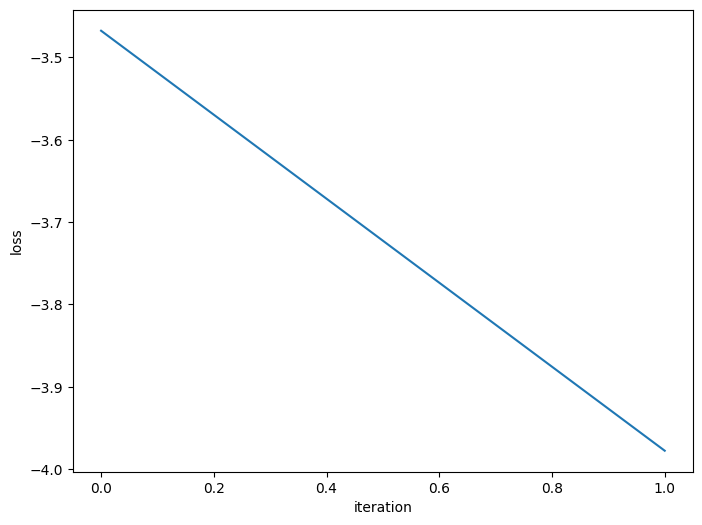

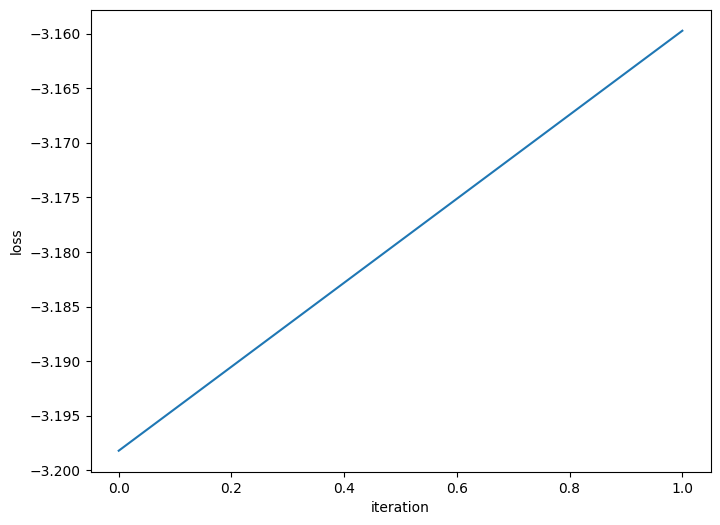

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -619.68834  validloss -575.07093±0.00000  bestvalidloss -575.07093  last_update 0
train: iter 1  trainloss -620.50807  validloss -585.52687±0.00000  bestvalidloss -585.52687  last_update 0
train: iter 2  trainloss -632.00989  validloss -567.30980±0.00000  bestvalidloss -585.52687  last_update 1
train: iter 3  trainloss -648.34437  validloss -560.78760±0.00000  bestvalidloss -585.52687  last_update 2
train: iter 4  trainloss -603.15774  validloss -548.36393±0.00000  bestvalidloss -585.52687  last_update 3
train: iter 5  trainloss -623.95367  validloss -459.63570±0.00000  bestvalidloss -585.52687  last_update 4
train: iter 6  trainloss -638.37101  validloss -552.41983±0.00000  bestvalidloss -585.52687  last_update 5
train: iter 7  trainloss -641.92526  validloss -550.46447±0.00000  bestvalidloss -585.52687  last_update 6
train: iter 8  trainloss -599.01199  validloss -553.86746±0.00000  bestvalidloss -585.52687  last_u

train: iter 76  trainloss -613.13574  validloss -570.15331±0.00000  bestvalidloss -585.97516  last_update 64
train: iter 77  trainloss -619.47586  validloss -543.80010±0.00000  bestvalidloss -585.97516  last_update 65
train: iter 78  trainloss -615.69591  validloss -534.34580±0.00000  bestvalidloss -585.97516  last_update 66
train: iter 79  trainloss -577.71584  validloss -474.09211±0.00000  bestvalidloss -585.97516  last_update 67
train: iter 80  trainloss -626.02343  validloss -535.72652±0.00000  bestvalidloss -585.97516  last_update 68
train: iter 81  trainloss -637.64004  validloss -563.94253±0.00000  bestvalidloss -585.97516  last_update 69
train: iter 82  trainloss -624.53226  validloss -548.78019±0.00000  bestvalidloss -585.97516  last_update 70
train: iter 83  trainloss -485.35572  validloss -524.01853±0.00000  bestvalidloss -585.97516  last_update 71
train: iter 84  trainloss -586.36314  validloss -475.65504±0.00000  bestvalidloss -585.97516  last_update 72
train: iter 85  tra

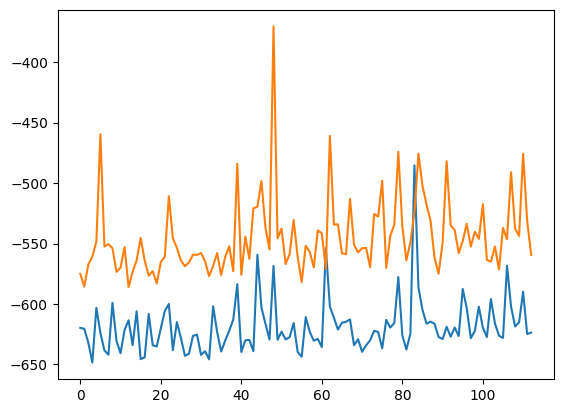

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-31 09:11:20.297021


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69
predict diverge [ 2.04932395  2.21728793 33.5489867  30.87205038] [0.18613546 0.69105982 1.28557868 1.1201266 ] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 67

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.39719  validloss 0.40816±0.00000  bestvalidloss 0.40816  last_update 0
train: iter 1  trainloss 0.34424  validloss 0.31905±0.00000  bestvalidloss 0.31905  last_update 0
train: iter 2  trainloss 0.33390  validloss 0.32016±0.00000  bestvalidloss 0.31905  last_update 1
train: iter 3  trainloss 0.32657  validloss 0.31020±0.00000  bestvalidloss 0.31020  last_update 0
train: iter 4  trainloss 0.32822  validloss 0.31476±0.00000  bestvalidloss 0.31020  last_update 1
train: iter 5  trainloss 0.32737  validloss 0.31622±0.00000  bestvalidloss 0.31020  last_update 2
train: iter 6  trainloss 0.32617  validloss 0.32182±0.00000  bestvalidloss 0.31020  last_update 3
train: iter 7  trainloss 0.32170  validloss 0.30329±0.00000  bestvalidloss 0.30329  last_update 0
train: iter 8  trainloss 0.31974  validloss 0.30414±0.00000  bestvalidloss 0.30329  last_update 1
train: iter 9  trainloss 0.31387  validloss 0.31034±0.00000  bestvalidloss 0.30329  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.27692  validloss 0.30183±0.00000  bestvalidloss 0.28571  last_update 1
train: iter 84  trainloss 0.27342  validloss 0.29107±0.00000  bestvalidloss 0.28571  last_update 2
train: iter 85  trainloss 0.27744  validloss 0.29491±0.00000  bestvalidloss 0.28571  last_update 3
train: iter 86  trainloss 0.27526  validloss 0.29022±0.00000  bestvalidloss 0.28571  last_update 4
train: iter 87  trainloss 0.27521  validloss 0.28953±0.00000  bestvalidloss 0.28571  last_update 5
train: iter 88  trainloss 0.27535  validloss 0.29768±0.00000  bestvalidloss 0.28571  last_update 6
train: iter 89  trainloss 0.27498  validloss 0.28542±0.00000  bestvalidloss 0.28542  last_update 0
train: iter 90  trainloss 0.27574  validloss 0.28833±0.00000  bestvalidloss 0.28542  last_update 1
train: iter 91  trainloss 0.27851  validloss 0.29124±0.00000  bestvalidloss 0.28542  last_update 2
train: iter 92  trainloss 0.27256  validloss 0.29324±0.00000  bestvalidloss 0.28542  last_update 3
train: ite

train: iter 165  trainloss 0.26174  validloss 0.28541±0.00000  bestvalidloss 0.28350  last_update 18
train: iter 166  trainloss 0.26470  validloss 0.28988±0.00000  bestvalidloss 0.28350  last_update 19
train: iter 167  trainloss 0.26533  validloss 0.29409±0.00000  bestvalidloss 0.28350  last_update 20
train: iter 168  trainloss 0.26267  validloss 0.29587±0.00000  bestvalidloss 0.28350  last_update 21
train: iter 169  trainloss 0.26262  validloss 0.29211±0.00000  bestvalidloss 0.28350  last_update 22
train: iter 170  trainloss 0.26287  validloss 0.28436±0.00000  bestvalidloss 0.28350  last_update 23
train: iter 171  trainloss 0.26127  validloss 0.29317±0.00000  bestvalidloss 0.28350  last_update 24
train: iter 172  trainloss 0.25981  validloss 0.29089±0.00000  bestvalidloss 0.28350  last_update 25
train: iter 173  trainloss 0.26434  validloss 0.29123±0.00000  bestvalidloss 0.28350  last_update 26
train: iter 174  trainloss 0.26224  validloss 0.29490±0.00000  bestvalidloss 0.28350  last_

train: iter 247  trainloss 0.25229  validloss 0.29246±0.00000  bestvalidloss 0.28227  last_update 70
train: iter 248  trainloss 0.25347  validloss 0.29497±0.00000  bestvalidloss 0.28227  last_update 71
train: iter 249  trainloss 0.25927  validloss 0.30227±0.00000  bestvalidloss 0.28227  last_update 72
train: iter 250  trainloss 0.25495  validloss 0.28797±0.00000  bestvalidloss 0.28227  last_update 73
train: iter 251  trainloss 0.25305  validloss 0.28314±0.00000  bestvalidloss 0.28227  last_update 74
train: iter 252  trainloss 0.25354  validloss 0.28986±0.00000  bestvalidloss 0.28227  last_update 75
train: iter 253  trainloss 0.25060  validloss 0.28914±0.00000  bestvalidloss 0.28227  last_update 76
train: iter 254  trainloss 0.25114  validloss 0.29161±0.00000  bestvalidloss 0.28227  last_update 77
train: iter 255  trainloss 0.25097  validloss 0.30808±0.00000  bestvalidloss 0.28227  last_update 78
train: iter 256  trainloss 0.24975  validloss 0.29616±0.00000  bestvalidloss 0.28227  last_

train_loss:  -5.836523686143756
valid_loss:  -6.607752894496917
weight_alpha 1.0 h_min_tilde -11.684047 ell_tilde -5.990769527814389 kappa_tilde 0.00041910113259245124
train_loss:  -3.1052411224365235
valid_loss:  -2.8107100856781004
weight_alpha 0.1 h_min_tilde -11.684047 ell_tilde -3.046334915084839 kappa_tilde 0.0003402519669272752


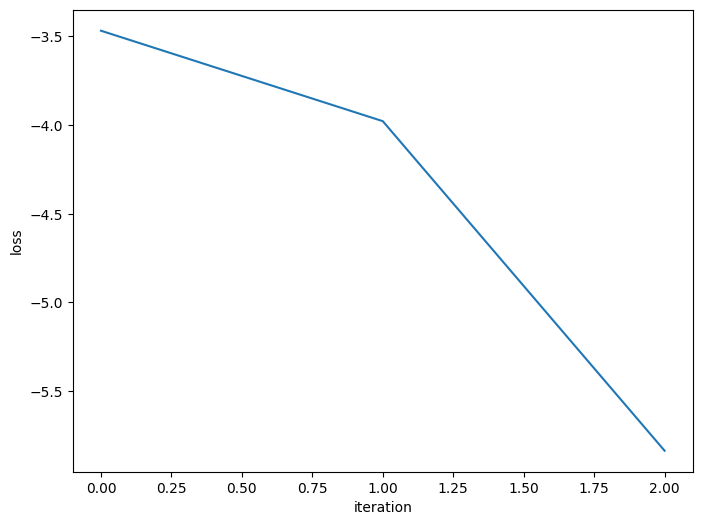

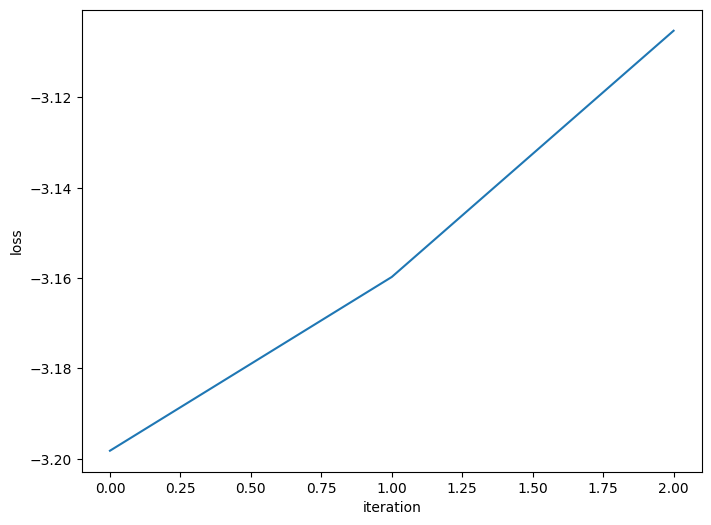

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -610.85785  validloss -565.00873±0.00000  bestvalidloss -565.00873  last_update 0
train: iter 1  trainloss -603.19454  validloss -554.60057±0.00000  bestvalidloss -565.00873  last_update 1
train: iter 2  trainloss -586.07490  validloss -559.69364±0.00000  bestvalidloss -565.00873  last_update 2
train: iter 3  trainloss -620.91190  validloss -542.36138±0.00000  bestvalidloss -565.00873  last_update 3
train: iter 4  trainloss -618.50841  validloss -561.20036±0.00000  bestvalidloss -565.00873  last_update 4
train: iter 5  trainloss -582.78313  validloss -561.49570±0.00000  bestvalidloss -565.00873  last_update 5
train: iter 6  trainloss -576.31583  validloss -523.01859±0.00000  bestvalidloss -565.00873  last_update 6
train: iter 7  trainloss -613.23794  validloss -522.74930±0.00000  bestvalidloss -565.00873  last_update 7
train: iter 8  trainloss -602.70780  validloss -541.24827±0.00000  bestvalidloss -565.00873  last_u

train: iter 75  trainloss -543.40371  validloss -482.73346±0.00000  bestvalidloss -565.00873  last_update 75
train: iter 76  trainloss -586.59234  validloss -506.10405±0.00000  bestvalidloss -565.00873  last_update 76
train: iter 77  trainloss -585.48979  validloss -528.00872±0.00000  bestvalidloss -565.00873  last_update 77
train: iter 78  trainloss -610.03170  validloss -527.25698±0.00000  bestvalidloss -565.00873  last_update 78
train: iter 79  trainloss -590.31350  validloss -546.40159±0.00000  bestvalidloss -565.00873  last_update 79
train: iter 80  trainloss -615.18401  validloss -546.41362±0.00000  bestvalidloss -565.00873  last_update 80
train: iter 81  trainloss -618.31646  validloss -542.69941±0.00000  bestvalidloss -565.00873  last_update 81
train: iter 82  trainloss -602.58054  validloss -536.40024±0.00000  bestvalidloss -565.00873  last_update 82
train: iter 83  trainloss -305.04774  validloss -336.18360±0.00000  bestvalidloss -565.00873  last_update 83
train: iter 84  tra

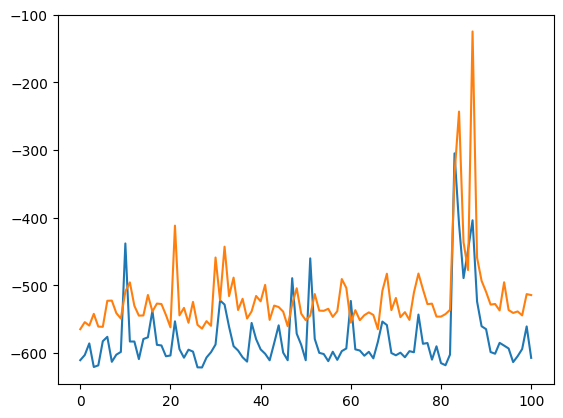

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-31 10:03:50.637801


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.32628  validloss 0.51444±0.00000  bestvalidloss 0.51444  last_update 0
train: iter 1  trainloss 0.31058  validloss 0.43533±0.00000  bestvalidloss 0.43533  last_update 0
train: iter 2  trainloss 0.30802  validloss 0.42817±0.00000  bestvalidloss 0.42817  last_update 0
train: iter 3  trainloss 0.30515  validloss 0.42662±0.00000  bestvalidloss 0.42662  last_update 0
train: iter 4  trainloss 0.30447  validloss 0.42240±0.00000  bestvalidloss 0.42240  last_update 0
train: iter 5  trainloss 0.30282  validloss 0.42179±0.00000  bestvalidloss 0.42179  last_update 0
train: iter 6  trainloss 0.30246  validloss 0.43117±0.00000  bestvalidloss 0.42179  last_update 1
train: iter 7  trainloss 0.30091  validloss 0.42069±0.00000  bestvalidloss 0.42069  last_update 0
train: iter 8  trainloss 0.29854  validloss 0.41217±0.00000  bestvalidloss 0.41217  last_update 0
train: iter 9  trainloss 0.29882  validloss 0.41990±0.00000  bestvalidloss 0.41217  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.27553  validloss 0.41536±0.00000  bestvalidloss 0.40048  last_update 8
train: iter 84  trainloss 0.28207  validloss 0.43843±0.00000  bestvalidloss 0.40048  last_update 9
train: iter 85  trainloss 0.27960  validloss 0.40984±0.00000  bestvalidloss 0.40048  last_update 10
train: iter 86  trainloss 0.27818  validloss 0.40696±0.00000  bestvalidloss 0.40048  last_update 11
train: iter 87  trainloss 0.27744  validloss 0.41832±0.00000  bestvalidloss 0.40048  last_update 12
train: iter 88  trainloss 0.27906  validloss 0.40845±0.00000  bestvalidloss 0.40048  last_update 13
train: iter 89  trainloss 0.27533  validloss 0.41868±0.00000  bestvalidloss 0.40048  last_update 14
train: iter 90  trainloss 0.27571  validloss 0.42291±0.00000  bestvalidloss 0.40048  last_update 15
train: iter 91  trainloss 0.27536  validloss 0.41433±0.00000  bestvalidloss 0.40048  last_update 16
train: iter 92  trainloss 0.27792  validloss 0.40804±0.00000  bestvalidloss 0.40048  last_update 17
tr

train: iter 165  trainloss 0.26775  validloss 0.44479±0.00000  bestvalidloss 0.40048  last_update 90
train: iter 166  trainloss 0.27064  validloss 0.41361±0.00000  bestvalidloss 0.40048  last_update 91
train: iter 167  trainloss 0.26843  validloss 0.41955±0.00000  bestvalidloss 0.40048  last_update 92
train: iter 168  trainloss 0.26919  validloss 0.41487±0.00000  bestvalidloss 0.40048  last_update 93
train: iter 169  trainloss 0.26783  validloss 0.42370±0.00000  bestvalidloss 0.40048  last_update 94
train: iter 170  trainloss 0.26734  validloss 0.42136±0.00000  bestvalidloss 0.40048  last_update 95
train: iter 171  trainloss 0.27270  validloss 0.41024±0.00000  bestvalidloss 0.40048  last_update 96
train: iter 172  trainloss 0.26799  validloss 0.41407±0.00000  bestvalidloss 0.40048  last_update 97
train: iter 173  trainloss 0.26584  validloss 0.42771±0.00000  bestvalidloss 0.40048  last_update 98
train: iter 174  trainloss 0.26710  validloss 0.43478±0.00000  bestvalidloss 0.40048  last_

train_loss:  -6.443247900176049
valid_loss:  -7.090058007001876
weight_alpha 1.0 h_min_tilde -11.768938 ell_tilde -6.572609921541214 kappa_tilde 0.0004386839201403272
train_loss:  -3.2499852193355565
valid_loss:  -2.8276932081222537
weight_alpha 0.1 h_min_tilde -11.768938 ell_tilde -3.165526817092896 kappa_tilde 0.00034092956044453184


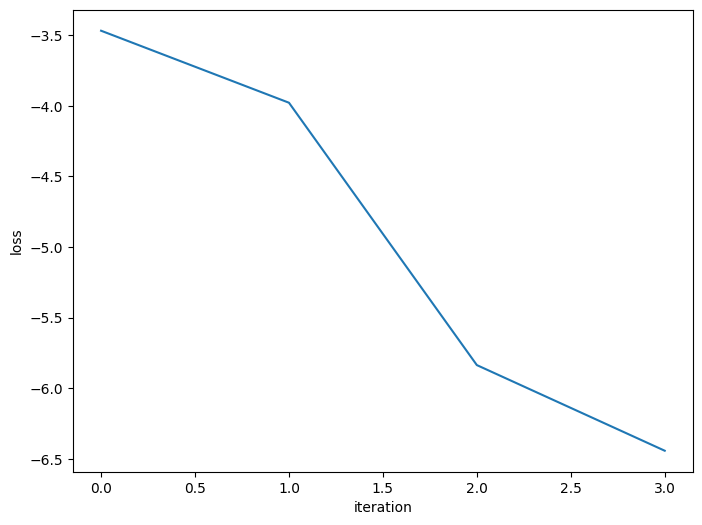

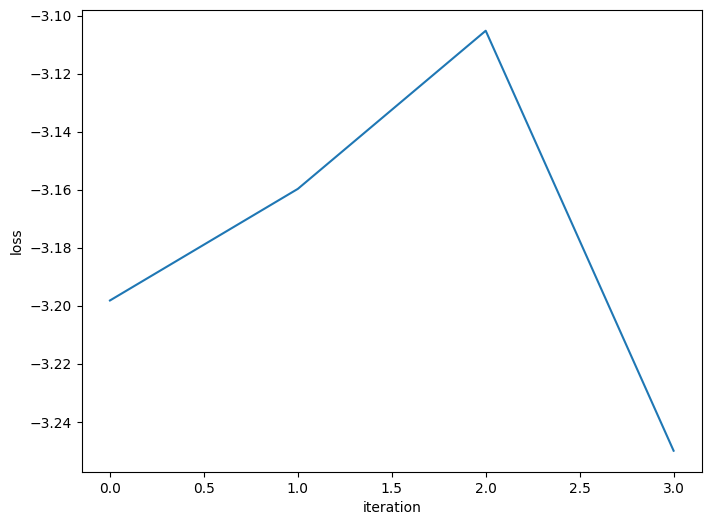

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -627.47773  validloss -563.47386±0.00000  bestvalidloss -563.47386  last_update 0
train: iter 1  trainloss -622.79070  validloss -534.07231±0.00000  bestvalidloss -563.47386  last_update 1
train: iter 2  trainloss -642.42523  validloss -574.66352±0.00000  bestvalidloss -574.66352  last_update 0
train: iter 3  trainloss -636.43040  validloss -581.35068±0.00000  bestvalidloss -581.35068  last_update 0
train: iter 4  trainloss -617.36392  validloss -420.87025±0.00000  bestvalidloss -581.35068  last_update 1
train: iter 5  trainloss -644.13439  validloss -546.07869±0.00000  bestvalidloss -581.35068  last_update 2
train: iter 6  trainloss -641.66240  validloss -535.61292±0.00000  bestvalidloss -581.35068  last_update 3
train: iter 7  trainloss -529.37347  validloss -552.31984±0.00000  bestvalidloss -581.35068  last_update 4
train: iter 8  trainloss -560.32559  validloss -441.52118±0.00000  bestvalidloss -581.35068  last_u

train: iter 76  trainloss -643.21265  validloss -583.61713±0.00000  bestvalidloss -586.47539  last_update 50
train: iter 77  trainloss -586.75136  validloss -510.73056±0.00000  bestvalidloss -586.47539  last_update 51
train: iter 78  trainloss -586.32995  validloss -449.75810±0.00000  bestvalidloss -586.47539  last_update 52
train: iter 79  trainloss -620.62986  validloss -557.52160±0.00000  bestvalidloss -586.47539  last_update 53
train: iter 80  trainloss -620.84918  validloss -508.72835±0.00000  bestvalidloss -586.47539  last_update 54
train: iter 81  trainloss -643.77795  validloss -541.67006±0.00000  bestvalidloss -586.47539  last_update 55
train: iter 82  trainloss -634.44126  validloss -555.57555±0.00000  bestvalidloss -586.47539  last_update 56
train: iter 83  trainloss -642.80943  validloss -402.09373±0.00000  bestvalidloss -586.47539  last_update 57
train: iter 84  trainloss -641.43382  validloss -526.96592±0.00000  bestvalidloss -586.47539  last_update 58
train: iter 85  tra

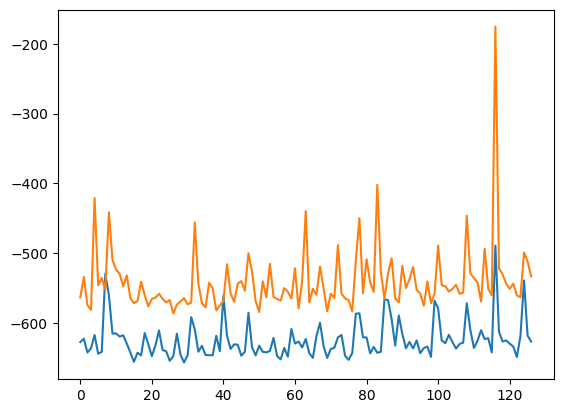

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-31 10:29:33.573313


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.37308  validloss 0.55075±0.00000  bestvalidloss 0.55075  last_update 0
train: iter 1  trainloss 0.35608  validloss 0.49643±0.00000  bestvalidloss 0.49643  last_update 0
train: iter 2  trainloss 0.34284  validloss 0.49539±0.00000  bestvalidloss 0.49539  last_update 0
train: iter 3  trainloss 0.33798  validloss 0.48649±0.00000  bestvalidloss 0.48649  last_update 0
train: iter 4  trainloss 0.33657  validloss 0.48879±0.00000  bestvalidloss 0.48649  last_update 1
train: iter 5  trainloss 0.33487  validloss 0.48599±0.00000  bestvalidloss 0.48599  last_update 0
train: iter 6  trainloss 0.33469  validloss 0.48938±0.00000  bestvalidloss 0.48599  last_update 1
train: iter 7  trainloss 0.33086  validloss 0.48381±0.00000  bestvalidloss 0.48381  last_update 0
train: iter 8  trainloss 0.33030  validloss 0.48312±0.00000  bestvalidloss 0.48312  last_update 0
train: iter 9  trainloss 0.32638  validloss 0.47976±0.00000  bestvalidloss 0.47976  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.30089  validloss 0.50703±0.00000  bestvalidloss 0.46988  last_update 35
train: iter 84  trainloss 0.30509  validloss 0.47760±0.00000  bestvalidloss 0.46988  last_update 36
train: iter 85  trainloss 0.30713  validloss 0.47558±0.00000  bestvalidloss 0.46988  last_update 37
train: iter 86  trainloss 0.30323  validloss 0.48456±0.00000  bestvalidloss 0.46988  last_update 38
train: iter 87  trainloss 0.30347  validloss 0.48538±0.00000  bestvalidloss 0.46988  last_update 39
train: iter 88  trainloss 0.30363  validloss 0.48043±0.00000  bestvalidloss 0.46988  last_update 40
train: iter 89  trainloss 0.30116  validloss 0.48279±0.00000  bestvalidloss 0.46988  last_update 41
train: iter 90  trainloss 0.30060  validloss 0.48448±0.00000  bestvalidloss 0.46988  last_update 42
train: iter 91  trainloss 0.30025  validloss 0.47641±0.00000  bestvalidloss 0.46988  last_update 43
train: iter 92  trainloss 0.30020  validloss 0.47819±0.00000  bestvalidloss 0.46988  last_update 44


train_loss:  -5.142615201309324
valid_loss:  -5.684945367813111
weight_alpha 1.0 h_min_tilde -11.86441 ell_tilde -5.251081234610082 kappa_tilde 0.0003888570080477781
train_loss:  -3.1045221255779265
valid_loss:  -2.6444066862106324
weight_alpha 0.1 h_min_tilde -11.86441 ell_tilde -3.012499037704467 kappa_tilde 0.0003361100293091535


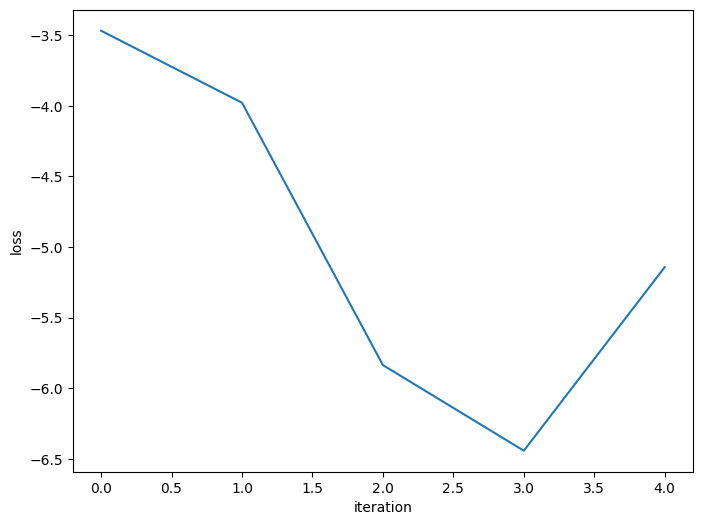

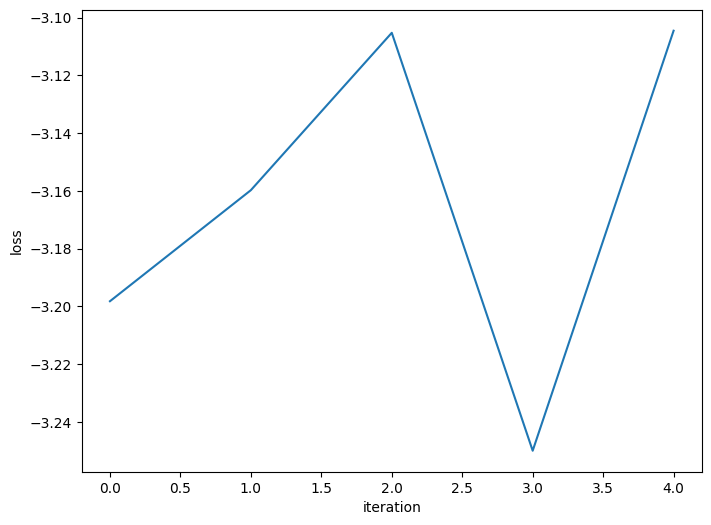

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -611.93074  validloss -530.94564±0.00000  bestvalidloss -530.94564  last_update 0
train: iter 1  trainloss -628.02986  validloss -527.84470±0.00000  bestvalidloss -530.94564  last_update 1
train: iter 2  trainloss -597.37685  validloss -530.04308±0.00000  bestvalidloss -530.94564  last_update 2
train: iter 3  trainloss -595.36469  validloss -490.44214±0.00000  bestvalidloss -530.94564  last_update 3
train: iter 4  trainloss -629.56290  validloss -550.04763±0.00000  bestvalidloss -550.04763  last_update 0
train: iter 5  trainloss -630.81797  validloss -559.15008±0.00000  bestvalidloss -559.15008  last_update 0
train: iter 6  trainloss -591.52030  validloss -412.51073±0.00000  bestvalidloss -559.15008  last_update 1
train: iter 7  trainloss -625.45646  validloss -540.41358±0.00000  bestvalidloss -559.15008  last_update 2
train: iter 8  trainloss -616.10225  validloss -538.54104±0.00000  bestvalidloss -559.15008  last_u

train: iter 76  trainloss -608.25559  validloss -532.35729±0.00000  bestvalidloss -561.73282  last_update 48
train: iter 77  trainloss -621.16399  validloss -518.89427±0.00000  bestvalidloss -561.73282  last_update 49
train: iter 78  trainloss -554.38792  validloss -520.17324±0.00000  bestvalidloss -561.73282  last_update 50
train: iter 79  trainloss -613.68767  validloss -556.98869±0.00000  bestvalidloss -561.73282  last_update 51
train: iter 80  trainloss -617.09616  validloss -543.55558±0.00000  bestvalidloss -561.73282  last_update 52
train: iter 81  trainloss -620.42124  validloss -547.86758±0.00000  bestvalidloss -561.73282  last_update 53
train: iter 82  trainloss -608.41406  validloss -519.61627±0.00000  bestvalidloss -561.73282  last_update 54
train: iter 83  trainloss -616.92081  validloss -499.01984±0.00000  bestvalidloss -561.73282  last_update 55
train: iter 84  trainloss -627.70491  validloss -548.54890±0.00000  bestvalidloss -561.73282  last_update 56
train: iter 85  tra

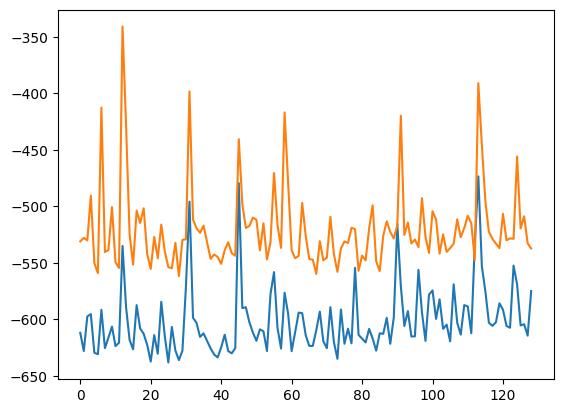

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-31 10:55:24.517850


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.35980  validloss 0.49255±0.00000  bestvalidloss 0.49255  last_update 0
train: iter 1  trainloss 0.33736  validloss 0.35754±0.00000  bestvalidloss 0.35754  last_update 0
train: iter 2  trainloss 0.33148  validloss 0.34725±0.00000  bestvalidloss 0.34725  last_update 0
train: iter 3  trainloss 0.32777  validloss 0.34081±0.00000  bestvalidloss 0.34081  last_update 0
train: iter 4  trainloss 0.32778  validloss 0.35085±0.00000  bestvalidloss 0.34081  last_update 1
train: iter 5  trainloss 0.32452  validloss 0.34371±0.00000  bestvalidloss 0.34081  last_update 2
train: iter 6  trainloss 0.32650  validloss 0.34961±0.00000  bestvalidloss 0.34081  last_update 3
train: iter 7  trainloss 0.32137  validloss 0.35035±0.00000  bestvalidloss 0.34081  last_update 4
train: iter 8  trainloss 0.32280  validloss 0.33886±0.00000  bestvalidloss 0.33886  last_update 0
train: iter 9  trainloss 0.31668  validloss 0.34794±0.00000  bestvalidloss 0.33886  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.29122  validloss 0.33314±0.00000  bestvalidloss 0.32421  last_update 15
train: iter 84  trainloss 0.29135  validloss 0.33514±0.00000  bestvalidloss 0.32421  last_update 16
train: iter 85  trainloss 0.29197  validloss 0.32833±0.00000  bestvalidloss 0.32421  last_update 17
train: iter 86  trainloss 0.28820  validloss 0.32683±0.00000  bestvalidloss 0.32421  last_update 18
train: iter 87  trainloss 0.29009  validloss 0.32632±0.00000  bestvalidloss 0.32421  last_update 19
train: iter 88  trainloss 0.29047  validloss 0.32589±0.00000  bestvalidloss 0.32421  last_update 20
train: iter 89  trainloss 0.28822  validloss 0.33388±0.00000  bestvalidloss 0.32421  last_update 21
train: iter 90  trainloss 0.28826  validloss 0.32347±0.00000  bestvalidloss 0.32347  last_update 0
train: iter 91  trainloss 0.29104  validloss 0.32922±0.00000  bestvalidloss 0.32347  last_update 1
train: iter 92  trainloss 0.28783  validloss 0.32866±0.00000  bestvalidloss 0.32347  last_update 2
tra

train: iter 165  trainloss 0.27394  validloss 0.34318±0.00000  bestvalidloss 0.32116  last_update 55
train: iter 166  trainloss 0.27349  validloss 0.32749±0.00000  bestvalidloss 0.32116  last_update 56
train: iter 167  trainloss 0.27383  validloss 0.33109±0.00000  bestvalidloss 0.32116  last_update 57
train: iter 168  trainloss 0.27394  validloss 0.34303±0.00000  bestvalidloss 0.32116  last_update 58
train: iter 169  trainloss 0.27830  validloss 0.36619±0.00000  bestvalidloss 0.32116  last_update 59
train: iter 170  trainloss 0.27536  validloss 0.32567±0.00000  bestvalidloss 0.32116  last_update 60
train: iter 171  trainloss 0.27490  validloss 0.34511±0.00000  bestvalidloss 0.32116  last_update 61
train: iter 172  trainloss 0.27310  validloss 0.33767±0.00000  bestvalidloss 0.32116  last_update 62
train: iter 173  trainloss 0.27547  validloss 0.33939±0.00000  bestvalidloss 0.32116  last_update 63
train: iter 174  trainloss 0.27650  validloss 0.34488±0.00000  bestvalidloss 0.32116  last_

([0.35980237256735564,
  0.33736116364598273,
  0.3314761336892843,
  0.3277722499333322,
  0.3277823678217828,
  0.32451911401003597,
  0.32649758625775577,
  0.32136913668364286,
  0.3228027537465096,
  0.31667595263570547,
  0.3190383612178266,
  0.31489560855552556,
  0.31553859990090133,
  0.3154123150743544,
  0.31307616783306,
  0.3148730405606329,
  0.3102573902346194,
  0.3119972594082355,
  0.31164021594449876,
  0.3100630802102387,
  0.3108952215872705,
  0.30793768763542173,
  0.31045426046475766,
  0.30947788739576937,
  0.30897760661318896,
  0.31319880597293376,
  0.3099993260577321,
  0.30683145206421614,
  0.30886520398780704,
  0.3046170987188816,
  0.3053325292654335,
  0.3081795278005302,
  0.30445856554433703,
  0.3058729088865221,
  0.30527291912585497,
  0.3051804852671921,
  0.30655637513846157,
  0.3030224174261093,
  0.3044324118643999,
  0.30115480786189436,
  0.3036091636866331,
  0.301486312225461,
  0.30022775223478676,
  0.3007037049159408,
  0.3018674468

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.701937577906253
valid_loss:  -8.114685512137413
weight_alpha 1.0 h_min_tilde -11.334198 ell_tilde -6.984487164752485 kappa_tilde 0.0004794792384665405
train_loss:  -2.77162209829092
valid_loss:  -2.324435659980774
weight_alpha 0.1 h_min_tilde -11.334198 ell_tilde -2.6821848106288906 kappa_tilde 0.0003399706406441166


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 87.52527  validloss 93.27919±0.00000  bestvalidloss 93.27919  last_update 0
train: iter 1  trainloss 70.97672  validloss 75.31437±0.00000  bestvalidloss 75.31437  last_update 0
train: iter 2  trainloss 57.32215  validloss 60.46745±0.00000  bestvalidloss 60.46745  last_update 0
train: iter 3  trainloss 46.88878  validloss 49.06167±0.00000  bestvalidloss 49.06167  last_update 0
train: iter 4  trainloss 38.28226  validloss 39.69004±0.00000  bestvalidloss 39.69004  last_update 0
train: iter 5  trainloss 31.52245  validloss 31.84031±0.00000  bestvalidloss 31.84031  last_update 0
train: iter 6  trainloss 26.08894  validloss 26.70985±0.00000  bestvalidloss 26.70985  last_update 0
train: iter 7  trainloss 21.44543  validloss 21.82827±0.00000  bestvalidloss 21.82827  last_update 0
train: iter 8  trainloss 17.77292  validloss 17.83388±0.00000  bestvalidloss 17.83388  last_update 0
train: iter 9  trainloss 14.82131  validloss 14.97358±0.00000  bestvalidloss 14.97358  last

train: iter 94  trainloss -0.16857  validloss -0.42699±0.00000  bestvalidloss -0.54498  last_update 12
train: iter 95  trainloss -0.18219  validloss -0.47930±0.00000  bestvalidloss -0.54498  last_update 13
train: iter 96  trainloss -0.14751  validloss -0.44719±0.00000  bestvalidloss -0.54498  last_update 14
train: iter 97  trainloss -0.17590  validloss -0.56680±0.00000  bestvalidloss -0.56680  last_update 0
train: iter 98  trainloss -0.16790  validloss -0.45918±0.00000  bestvalidloss -0.56680  last_update 1
train: iter 99  trainloss -0.17884  validloss -0.44681±0.00000  bestvalidloss -0.56680  last_update 2
train: iter 100  trainloss -0.20314  validloss -0.48735±0.00000  bestvalidloss -0.56680  last_update 3
train: iter 101  trainloss -0.20160  validloss -0.43483±0.00000  bestvalidloss -0.56680  last_update 4
train: iter 102  trainloss -0.17197  validloss -0.47539±0.00000  bestvalidloss -0.56680  last_update 5
train: iter 103  trainloss -0.17468  validloss -0.49097±0.00000  bestvalidlo

train: iter 175  trainloss -0.17349  validloss -0.43083±0.00000  bestvalidloss -0.56680  last_update 78
train: iter 176  trainloss -0.20594  validloss -0.40313±0.00000  bestvalidloss -0.56680  last_update 79
train: iter 177  trainloss -0.18026  validloss -0.39512±0.00000  bestvalidloss -0.56680  last_update 80
train: iter 178  trainloss -0.15714  validloss -0.44100±0.00000  bestvalidloss -0.56680  last_update 81
train: iter 179  trainloss -0.17499  validloss -0.40400±0.00000  bestvalidloss -0.56680  last_update 82
train: iter 180  trainloss -0.19248  validloss -0.45701±0.00000  bestvalidloss -0.56680  last_update 83
train: iter 181  trainloss -0.18742  validloss -0.47877±0.00000  bestvalidloss -0.56680  last_update 84
train: iter 182  trainloss -0.20638  validloss -0.39388±0.00000  bestvalidloss -0.56680  last_update 85
train: iter 183  trainloss -0.15240  validloss -0.46530±0.00000  bestvalidloss -0.56680  last_update 86
train: iter 184  trainloss -0.17483  validloss -0.40146±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.9438, -2.4030, -2.0111, -4.1548], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 19.27747  validloss 22.25599±0.00000  bestvalidloss 22.25599  last_update 0
train: iter 1  trainloss 17.44684  validloss 21.67852±0.00000  bestvalidloss 21.67852  last_update 0
train: iter 2  trainloss 16.28564  validloss 23.36972±0.00000  bestvalidloss 21.67852  last_update 1
train: iter 3  trainloss 16.38412  validloss 21.38919±0.00000  bestvalidloss 21.38919  last_update 0
train: iter 4  trainloss 16.05609  validloss 21.05333±0.00000  bestvalidloss 21.05333  last_update 0
train: iter 5  trainloss 16.26101  validloss 20.90074±0.00000  bestvalidloss 20.90074  last_update 0
train: iter 6  trainloss 15.97386  validloss 20.99653±0.00000  bestvalidloss 20.90074  last_update 1
train: iter 7  trainloss 15.89659  validloss 22.20214±0.00000  bestvalidloss 20.90074  last_update 2
train: iter 8  trainloss 16.44395  validloss 21.31042±0.00000  bestvalidloss 20.90074  last_update 3
train: iter 9  trainloss 15.75802  validloss 19.93545±0.00000  bestvalidloss 19.93545  last

train: iter 81  trainloss 15.08346  validloss 20.25999±0.00000  bestvalidloss 18.68612  last_update 6
train: iter 82  trainloss 14.77685  validloss 20.06183±0.00000  bestvalidloss 18.68612  last_update 7
train: iter 83  trainloss 15.67251  validloss 20.01589±0.00000  bestvalidloss 18.68612  last_update 8
train: iter 84  trainloss 15.12390  validloss 20.10724±0.00000  bestvalidloss 18.68612  last_update 9
train: iter 85  trainloss 15.40595  validloss 19.47258±0.00000  bestvalidloss 18.68612  last_update 10
train: iter 86  trainloss 15.41553  validloss 19.91594±0.00000  bestvalidloss 18.68612  last_update 11
train: iter 87  trainloss 15.03115  validloss 19.39983±0.00000  bestvalidloss 18.68612  last_update 12
train: iter 88  trainloss 14.48067  validloss 20.41866±0.00000  bestvalidloss 18.68612  last_update 13
train: iter 89  trainloss 15.65345  validloss 20.56056±0.00000  bestvalidloss 18.68612  last_update 14
train: iter 90  trainloss 15.26949  validloss 21.24398±0.00000  bestvalidloss

train: iter 161  trainloss 14.89040  validloss 20.21055±0.00000  bestvalidloss 18.63021  last_update 40
train: iter 162  trainloss 14.92268  validloss 19.74112±0.00000  bestvalidloss 18.63021  last_update 41
train: iter 163  trainloss 14.85005  validloss 21.26203±0.00000  bestvalidloss 18.63021  last_update 42
train: iter 164  trainloss 13.88596  validloss 19.95719±0.00000  bestvalidloss 18.63021  last_update 43
train: iter 165  trainloss 14.51874  validloss 20.34419±0.00000  bestvalidloss 18.63021  last_update 44
train: iter 166  trainloss 14.25492  validloss 20.87251±0.00000  bestvalidloss 18.63021  last_update 45
train: iter 167  trainloss 14.59322  validloss 19.65333±0.00000  bestvalidloss 18.63021  last_update 46
train: iter 168  trainloss 14.86310  validloss 18.99189±0.00000  bestvalidloss 18.63021  last_update 47
train: iter 169  trainloss 14.67871  validloss 20.11030±0.00000  bestvalidloss 18.63021  last_update 48
train: iter 170  trainloss 14.56582  validloss 19.50110±0.00000 

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-9.5128)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(12.0984)


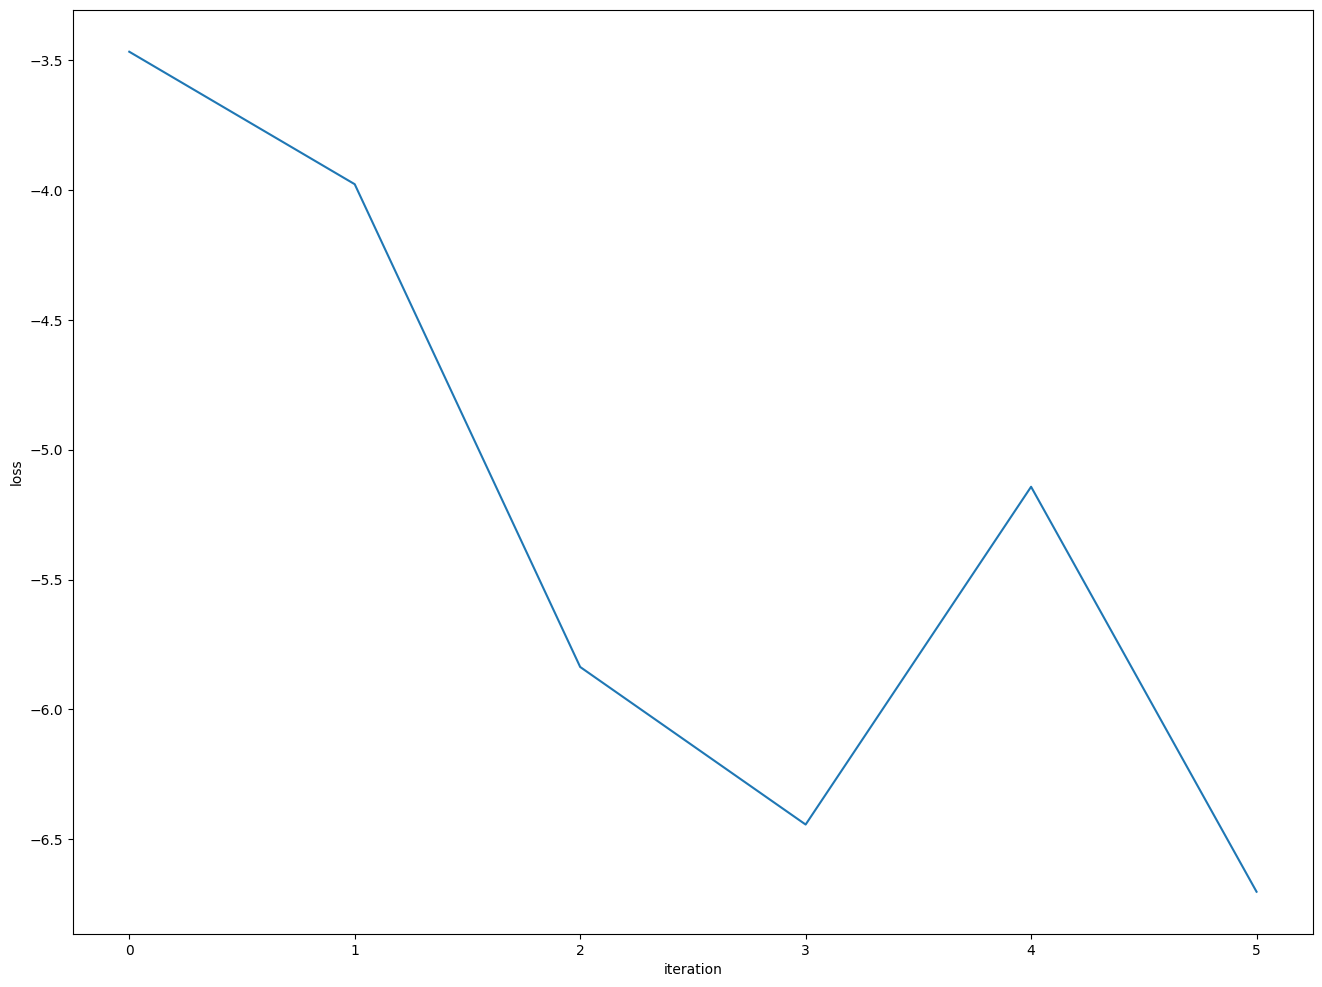

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

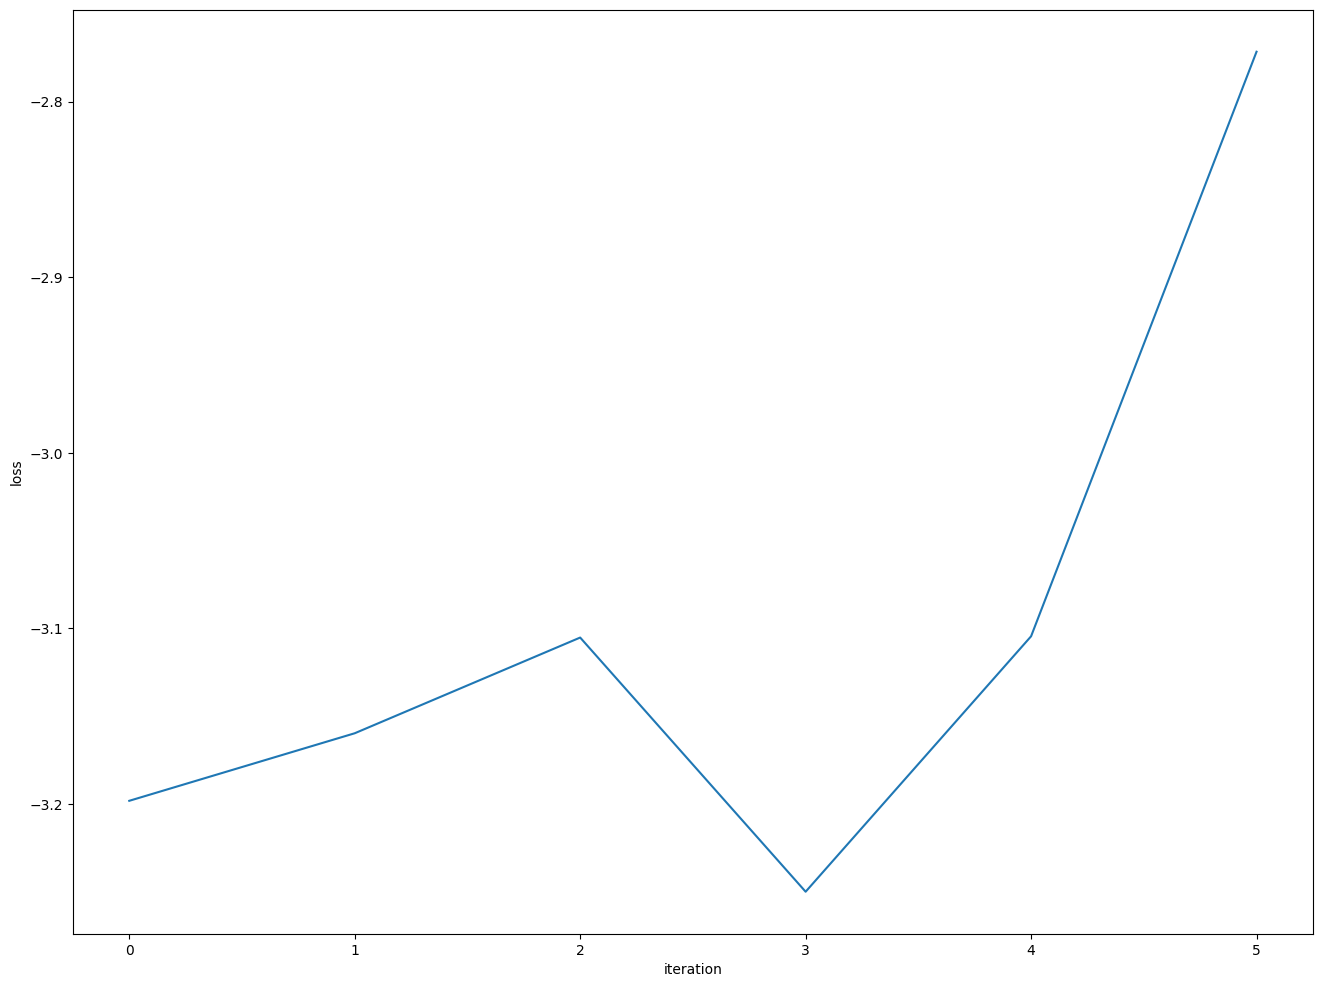

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")